# INF5007 Neural Networks / Neuroniniai tinklai
**LAB7**

## HOMEWORK TASK

You can use LSTM networks in your individual work.

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

## LSTM network on same data used for RNN

In [2]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

def plot_timeseries(date, temp):
    # Plot daily median temperatures in Canberra
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=date,
                            y=temp,
                            mode='lines',
                            name='Median Temperature',
                            opacity=0.8,
                            line=dict(color='black', width=1)
                            ))

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Date'
                    )

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Degrees Celsius'
                    )

    # Set figure title
    fig.update_layout(title=dict(text="Median Daily Temperatures in Canberra",
                                font=dict(color='black')))

    fig.show()

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/vytkuc/inf5007_2023_autumn/master/lab6_RNN/lab_data.csv')
df

,Date,MedTemp
0,2007-11-01,16.15
1,2007-11-02,20.45
2,2007-11-03,18.55
3,2007-11-04,14.40
4,2007-11-05,11.85
...,...,...
3423,2017-06-21,6.15
3424,2017-06-22,6.75
3425,2017-06-23,5.20
3426,2017-06-24,7.25


In [4]:
plot_timeseries(df.Date, df.MedTemp)

### Data preparation

In [5]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

#data_array = np.array(df.MedTemp.astype('float32'))
X = np.array(df.MedTemp).reshape(-1, 1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train / Test split (initial only)
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(X_scaled, test_size=0.2, shuffle=False)
print(train_data.shape, test_data.shape)

def get_XY(dat, time_steps):
    # Prepare Y
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]

    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))

    return X, Y

time_steps = 7
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

(2742, 1) (686, 1)


### Model definition

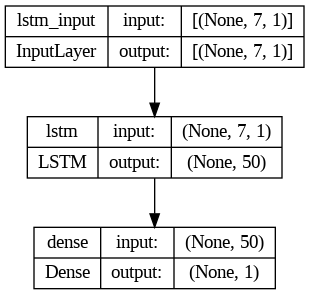

In [6]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.utils import plot_model

np.random.seed(1330)

def create_model():
    model = keras.Sequential(
        [
            layers.LSTM(50, activation='relu', input_shape=(time_steps, 1)),
            layers.Dense(units = 1, activation = "linear"),
        ]
    )
    return model


model = create_model()
plot_model(model, show_shapes=True, show_layer_names=True)
#model.summary()

In [7]:
model.compile(loss='mean_squared_error',
              metrics=['MeanSquaredError', 'MeanAbsoluteError'],
              optimizer='adam')

model.fit(trainX,
          trainY,
          batch_size=1,
          epochs=20,
          verbose=0,
          shuffle=True,
         )

In [8]:
from sklearn.metrics import mean_squared_error

pred_train = model.predict(trainX)
pred_test = model.predict(testX)

print('---------- Evaluation on Training Data ----------')
print("MSE =", mean_squared_error(trainY, pred_train))
print("")

print('---------- Evaluation on Test Data ----------')
print("MSE =", mean_squared_error(testY, pred_test))
print("")

4/4 [==============================] - 0s 4ms/step
---------- Evaluation on Training Data ----------
MSE = 0.005807608471355349

---------- Evaluation on Test Data ----------
MSE = 0.0063818942835961595



In [9]:
def plot_predicted(true_data, pred_data):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.array(range(0,len(true_data))),
                            y=scaler.inverse_transform(true_data).flatten(),
                            mode='lines',
                            name='Median Temperature - Actual (Test)',
                            opacity=0.8,
                            line=dict(color='black', width=1)
                            ))
    fig.add_trace(go.Scatter(x=np.array(range(0,len(pred_data))),
                            y=scaler.inverse_transform(pred_data).flatten(),
                            mode='lines',
                            name='Median Temperature - Predicted (Test)',
                            opacity=0.8,
                            line=dict(color='red', width=1)
                            ))

    # Change chart background color
    fig.update_layout(dict(plot_bgcolor = 'white'))

    # Update axes lines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Observation'
                    )

    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
                    zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
                    showline=True, linewidth=1, linecolor='black',
                    title='Degrees Celsius'
                    )

    # Set figure title
    fig.update_layout(title=dict(text="Median Daily Temperatures in Canberra",
                                font=dict(color='black')),
                    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                    )

    fig.show()

In [10]:
plot_predicted(testY, pred_test)

## LSTM for character-level text generation

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io


#### Download the data

In [12]:
path = keras.utils.get_file(
    "nietzsche.txt", origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt"
)

with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")
print("Corpus length:", len(text))
text[:1000]

600901/600901 [==============================] - 0s 1us/step
Corpus length: 600893


'preface   supposing that truth is a woman--what then? is there not ground for suspecting that all philosophers, in so far as they have been dogmatists, have failed to understand women--that the terrible seriousness and clumsy importunity with which they have usually paid their addresses to truth, have been unskilled and unseemly methods for winning a woman? certainly she has never allowed herself to be won; and at present every kind of dogma stands with sad and discouraged mien--if, indeed, it stands at all! for there are scoffers who maintain that it has fallen, that all dogma lies on the ground--nay more, that it is at its last gasp. but to speak seriously, there are good grounds for hoping that all dogmatizing in philosophy, whatever solemn, whatever conclusive and decided airs it has assumed, may have been only a noble puerilism and tyronism; and probably the time is at hand when it will be once and again understood what has actually sufficed for the basis of such imposing and abs

#### Text data preparation

In [13]:
chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Total chars: 56
Number of sequences: 200285


In [17]:
chars

[' ',
 '!',
 '"',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '?',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'ä',
 'æ',
 'é',
 'ë']

### Define the model

In [14]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               94720     
                                                                 
 dense_1 (Dense)             (None, 56)                7224      
                                                                 
Total params: 101944 (398.22 KB)
Trainable params: 101944 (398.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.compile(loss='categorical_crossentropy',
              metrics=['MeanSquaredError', 'MeanAbsoluteError'],
              optimizer='adam')

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


### Training the model

In [16]:
# The network starts generating normal text starting from 40 epochs.
# Thought, it takes some time for it to train.
epochs = 40
batch_size = 1000

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print()


201/201 [==============================] - 161s 784ms/step - loss: 2.9445 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0329

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: "mplicity of form or because men though r"
...Generated:  e te the t os as the an t the t  oe  te the te th te te te the s a e an te t e  an te tare l ne te te te the  te te thes the s te t as an te the the the at t  the  o  the the a e an the ane tie ti te te te te the t ait te te ithe the aat t oe the e t ane at te  the the as te the te at t the te t an the te the t te te the ian  he the the te te the te an tiir te t the the te te at  an le the t te th

...Diversity: 0.5
...Generating with seed: "mplicity of form or because men though r"
...Generated:  edenn ehe ad te t he l mt hes cieesic t s t hel te the t en outes te  an a hatheroee s t n sse ferro ae n do oet therin o  te r ea  d are tn tlee otit ans  int eer t t e  treeree  o th it  atesed tf cpehe eanin n tsen unir  h th td

KeyboardInterrupt: ignored